# Data sense making

## Table Of Contents

 1. Case study: the most studied artistic and historical periods
     * 1.1. Acquire, parse, and filter data
     * 1.2. Mine data
     * 1.3. Represent: Profiling and exploration, plotting data 
 
 
 2. Case study: what are the most studied artistic and historical periods studied over time
     * 2.1. Acquire, parse, and filter data
     * 2.2. Mine data
     * 2.3. Represent: Profiling and exploration, plotting data 

Usually, the first step in understanding the added value of a given dataset requires the exploration to be performed **over the whole dataset**. However, tools for RDF data visualizations for exploratory and analysis purposes are not yet that common, are not easy-to-use for beginners, and may be confusing. 

For the sake of this tutorial, we start from (1) a given research question and (2) a subset of the ARTchives graph. 
The subset is selected in order to exemplify the phases of data sense making while trying to answer the following exploratory questions, exemplified as case studies.


## 1. Case study: the most studied artistic and historical periods

We want to answer the following question:

```
What are the most studied artistic and historical periods in the archival materials recorded in ARTchives?
```

This question implies us to get some **statistics**, i.e. the distribution of periods in the dataset, as being topics of archival collections
 
In order to answer this question we need to go through the seven stages of information visualization, namely:

 * acquire
 * parse
 * filter
 * mine
 * represent
 * refine
 * interact 
 
### 1.1. Acquire, parse, and filter data

#### 1.1.1. Acquisition and parsing

We leverage the RDF dump of ARTchives data (`../resources/artchives.nq`). We parse the data by using the RDFLib python library.

In [1]:
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS

# bind the uncommon namespaces
wd = Namespace("http://www.wikidata.org/entity/") # remember that a prefix matches a URI until the last slash (or hashtag #)
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")

# create an empty Graph
g = rdflib.ConjunctiveGraph()

# parse a local RDF file by specifying the format
result = g.parse("../resources/artchives.nq", format='nquads')

#### 1.1.2 Understand your data

In ARTchives we have: 

 * archival collections (individuals of the class `wd:Q9388534`)
 * subjects of the collections (`wd:Q9388534 > wdt:P921 > ?period`)
 * among subject we have artistic and historical periods. To make our life simpler, these are addressed both by `wdt:P921` among the others, and by a dedicated property called `art:hasSubjectPeriod`
 
#### 1.1.3 Filtering
In order to answer our research question we need to work only on a subset of the graph.

For the **statistical analysis**, we need to extract: 
 
 * the names of the artistic periods (values of the property `art:hasSubjectPeriod / rdfs:label`)
 * the number of collections addressing the artistic period (the number of times that topic is value of the property `art:hasSubjectPeriod`)

This is the simplest *univariate* analysis possible on a dataset. We consider a *categorial attribute* (the artistic period) and we look for the distribution of its values in the dataset. The aim is to discover which are the most popular topics (artistic periods) in the dataset.

**AND NOW?** To make the analysis faster and more focused, we extract the data we need for the sake of the analysis in **separate data structures** from the original one. In order to use some popular python library for plotting data in Jupyter, we must have data in **tabular form**.

**But why a table? what data should I put there? and what structure for the table? and what chart?** The chart you want to plot requires you to have data organised in some way, which is not likely to be a graph (if you are not working on networks). However, the plot should not be the final goal, but a flexible instrument to get to your results. Nonetheless, when working with graph data it's not that linear, and a good way of planning your work is:

 * you choose the research question
 * you get your data in some form
 * you choose the plot(s) that better help you to visualise some pattern
 * then you decide how to filter your data (select the variables that matter) 
 * create a data structure that fits the plotting requirements
 
In our case, we want to plot the distribution of periods in our dataset in a **bar chart**. Therefore we filter graph to get data about collections and subject periods, and we create a table wherein each row includes (1) a collection and (2) an artistic period.

Step by step:

 * We query our the graph, looking for periods and collections. Rather than iterating over triples, we use a sparql query. 
 

In [2]:
# query the graph
query_periods = g.query(
    """SELECT (SAMPLE(?coll_label) AS ?coll) (SAMPLE(?label) AS ?period_label) # we want only one label!
    WHERE {?coll <https://w3id.org/artchives/hasSubjectPeriod> ?period ; rdfs:label ?coll_label .
    ?period rdfs:label ?label .}
    GROUP BY ?period ?coll
    ORDER BY ?period_label""") 

# try the query on http://artchives.fondazionezeri.unibo.it/sparql to see the results!

* We prepare a table (a .csv file) with two columns (`collection`, `period_label`) and we write our results of the query there.

In [3]:
# import csv built-in library
import csv

# prepare the csv file
with open('periods_count.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['collection', 'period_label'])
    
    # access the list of tuples of the query results
    for res in query_periods:
        # write in the csv
        my_writer.writerow([res['coll'], res['period_label'].strip()])

### 1.2 Mine data

We introduce now **Pandas**, a Python library for **data analysis**. Pandas reuires us to parse data in new data structures called data frames (i.e. tables) so that we can use on these some useful methods for the analysis and visualization.

In [4]:
# pandas
import pandas as pd

# parse the csv into a dataframe
df = pd.read_csv("periods_count.csv")
# print the first 5 rows
df.head()

,collection,period_label
0,Fototeca Julian Kliemann,17th century
1,Fototeca Stefano Tumidei,17th century
2,Archivio Luisa Vertova,17th century
3,"Nachlass Fritz Heinemann, Notizen zur venezian...",17th century
4,Luigi Salerno research papers,17th century


### 1.3 Represent: Profiling and exploration, plotting data

Another useful library is **pandas_profiling** that generates reports from a pandas dataframe, including basic statistics on the datasets and a few exploratory visualizations. This is very useful when you are working on big tables with many columns and rows.

In [5]:
import pandas_profiling as pp
pp.ProfileReport(df)

To plot our data with Python in Jupyter we have plenty of libraries that support us. In this tutorial we use **seaborn**, a library for plotting data organised in data frames. See the [online documentation](https://seaborn.pydata.org/) with plenty of tutorials.

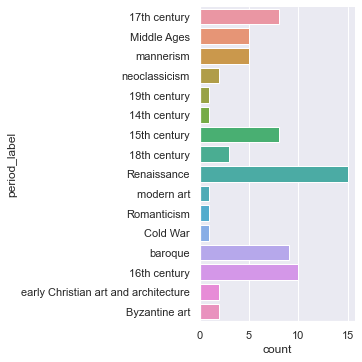

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
sns.set_theme()

# load data frame
periods = df

# count function to show the number of observations of a category (period_label) in a dataset as a bar chart
my_plot = sns.catplot(y="period_label", kind="count", data=periods)

The library allows us to save plots as images - possibly, to be included in a web page :)

In [7]:
my_plot.savefig("distribution.png")

## 2 Case study: what are the most studied artistic and historical periods studied over time

We want to answer the following question:

```
What are the most studied artistic and historical periods studied over time according to ARTchives?
```

This question implies us to get **temporal** insights, when and to what extent collections reference a certain artistic period,
 
In order to answer this question we need to go through the seven stages of information visualization, namely:

 * acquire
 * parse
 * filter
 * mine
 * represent
 * refine
 * interact 
 
 
### 2.1. Acquire, parse, and filter data

#### 2.1.1. Acquisition and parsing

We leverage the same RDF dump of ARTchives data (`../resources/artchives.nq`). We parse the data by using the RDFLib python library.

#### 2.1.2 Understand your data

 * archival collections are annotated with the timespan of the creator's activity (earliest date `wd:Q9388534 > wdt:P1319 > ?earliest` and latest date `wd:Q9388534 > wdt:P1326 > ?latest`)

#### 2.1.3 Filtering
In order to answer our research question we need to work only on a subset of the graph.

For the **temporal analysis**, we need to extract:  

 * the names of the artistic periods (values of the property `art:hasSubjectPeriod / rdfs:label`)
 * the timespans of collections (earliest `wdt:P1319` and latest `wdt:P1326`)

This is a *bivariate* analysis, looking for the distribution of a *categorial attribute* over time. The aim is to find an association between time spans and topics (artistic periods) in the dataset.

**AND NOW?** To make the analysis easier, we extract the data we need in **separate data structures** from the original one. In order to use some popular python library for plotting data in Jupyter, we must have data in **tabular form**. We want to plot our dataa in a **line graph**, where it's easier to see trends. 
Step by step:

 * We query our the graph, looking for subject periods, collections, collections dates. Rather than iterating over triples, we use a sparql query. We need to take into account that some collections may not have some variables. The results of our query will include in every row a unique combination of periods, collections, and collections dates, meaning that, if a period is referenced in more collections, there will be more rows for that period.


In [8]:
# sparql

query_periods_dates = g.query(
    """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    SELECT (SAMPLE(?coll_label) AS ?coll) (SAMPLE(?label) AS ?period_label) ?earliest ?latest
    WHERE {?coll <https://w3id.org/artchives/hasSubjectPeriod> ?period ; rdfs:label ?coll_label .
    ?period rdfs:label ?label .
    OPTIONAL {?coll wdt:P1319 ?earliest}
    OPTIONAL {?coll wdt:P1326 ?latest}
    }
    GROUP BY ?period ?coll ?earliest ?latest
    ORDER BY ?period_label""") 

### 2.2. Mine data

In order to plot periods distribution over time, we need a **time series**, meaning a **continuous** series of time observations (in our case we simplify observations to years). However, we have only time ranges (e.g. 1910-1986). We need to **expand the results** of the query with intermediate points.

 * We iterate over the results of the query (a list of tuples) and for each result (coll, period, earliest, latest) we create a new tuple (coll, period, year) where the year is a number included in the range(earliest,latest)
 * We create a python list to store the new tuples 

In [12]:
# the new list
periods_dates_expanded = []

# query the list of tuples of query results
for res in query_periods_dates:
    if res["earliest"] is not None and res["latest"] is not None:
        timespan = list(range( int(res["earliest"][:4]), int(res["latest"][:4])+1 ))
        for year in timespan:
            periods_dates_expanded.append( (res["coll"], res["period_label"], str(year)) ) # append a tuple!

* We prepare a table (a .csv file) with three columns (`collection`, `period_label`, `year`) and we write our results of the query there.

In [13]:

# prepare the csv file
with open('periods_dates.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['collection', 'period_label', 'year'])
    
    # access the rows of the query results
    for coll, label, year in periods_dates_expanded:
        # write in the csv
        my_writer.writerow([coll.strip(), label.strip(), year])

 * We parse the table in a data frame

In [14]:
# parse the csv into a dataframe
data = pd.read_csv("periods_dates.csv")
# print the first 5 rows
data.head()

,collection,period_label,year
0,"Nachlass Fritz Heinemann, Notizen zur venezian...",17th century,1925
1,"Nachlass Fritz Heinemann, Notizen zur venezian...",17th century,1926
2,"Nachlass Fritz Heinemann, Notizen zur venezian...",17th century,1927
3,"Nachlass Fritz Heinemann, Notizen zur venezian...",17th century,1928
4,"Nachlass Fritz Heinemann, Notizen zur venezian...",17th century,1929


In order to visualize the artistic periods through the time series (x axis), and the number of collections addressing the period (y axis), we need to re-organize the dataframe. Pandas allows us to create new dataframes from an existing one **by grouping rows** according to values included in one or more columns.

In [46]:
# group rows by period and year, hence add a column with the counting of collections
data_by_year = data.groupby( ["period_label", "year"] ).size().reset_index()
# rename the columns
data_by_year.columns = ["period_label", "year", "count_coll"]
# see the first rows
data_by_year.head()

,period_label,year,count_coll
0,14th century,1965,1
1,14th century,1966,1
2,14th century,1967,1
3,14th century,1968,1
4,14th century,1969,1


### 1.3 Represent: Profiling and exploration, plotting data


In [47]:
# profiling
pp.ProfileReport(data_by_year)

To make the initial exploration easier, we can create as many charts as the periods, by using **relplot** in seaborn.

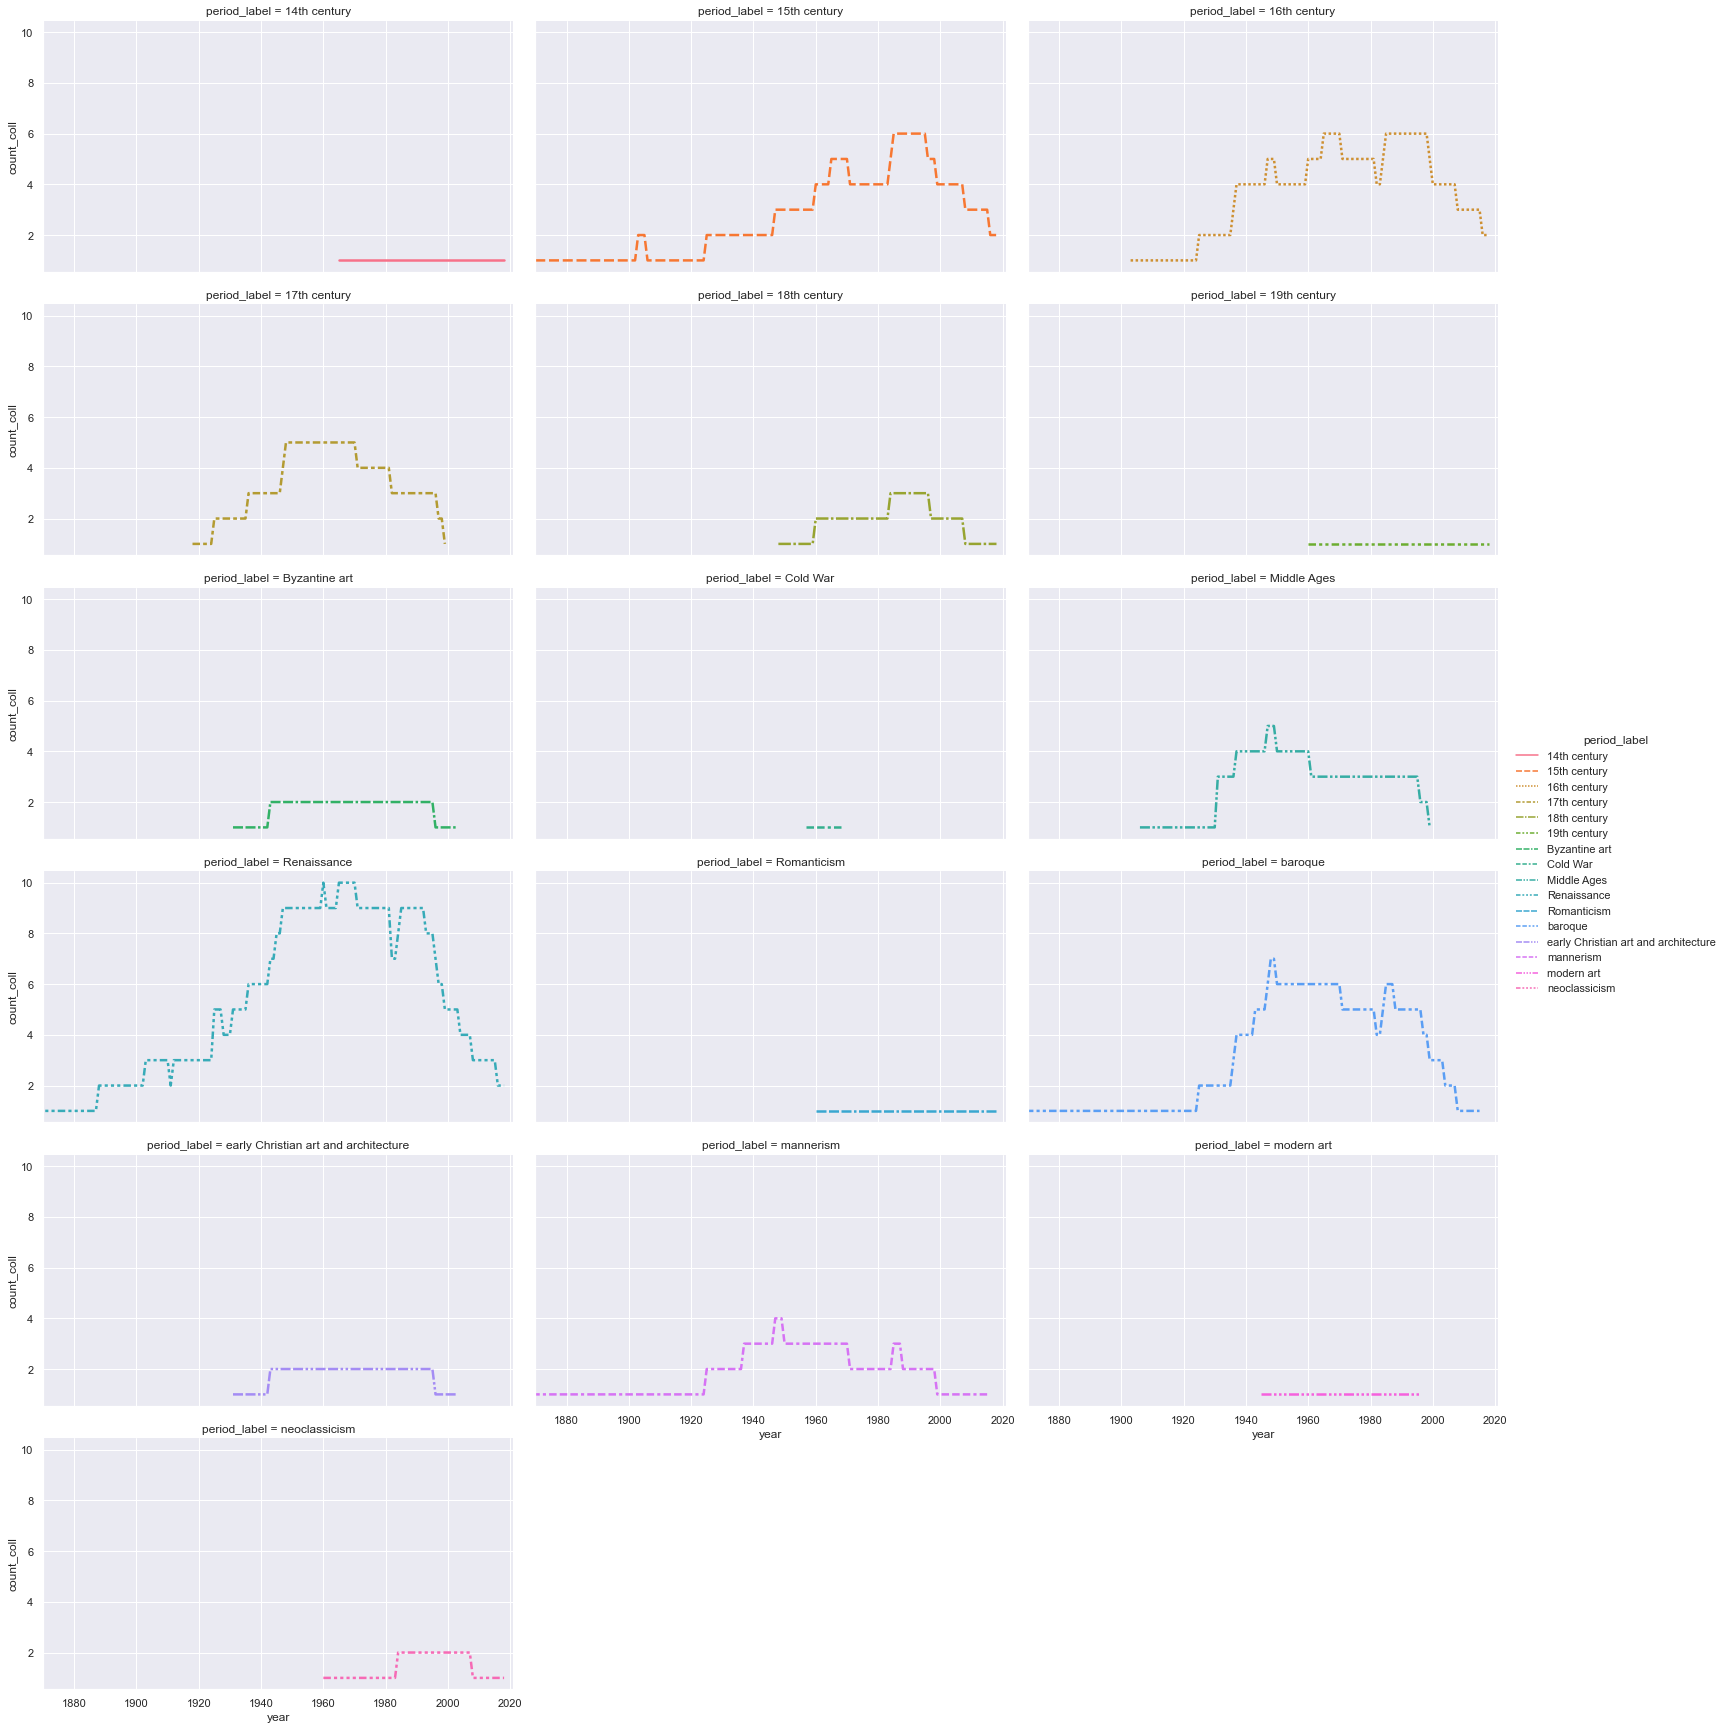

In [49]:
# plotting
mult_plot = sns.relplot(x="year", y="count_coll", hue="period_label", style="period_label",
            col="period_label", col_wrap=3,
            height=4, aspect=1.75, linewidth=2.5,
            kind="line", data=data_by_year);
# reset the x origin to year 1870
mult_plot.set(xlim=(1870, 2021)) 

We can now compare all the periods in the same plot.

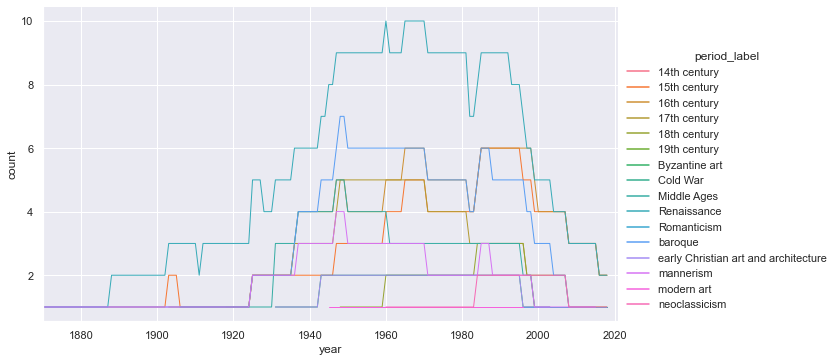

In [43]:
my_pl = sns.relplot(x="year", y="count_coll", hue="period_label",
            height=5, aspect=1.75, linewidth=1,
            kind="line", data=data_by_year);

# reset the x origin to year 1870
my_pl.set(xlim=(1870, 2021))

## An inspiration for your project

**geospatial analysis** whether there are correlations between studied historical periods and other variables in the dataset (e.g. historians' birth places)

For the **geospatial analysis**, you would need to extract:

 * the names of the artistic periods (values of the property `art:hasSubjectPeriod / rdfs:label`) 
 * the birthplaces of the historians collections (`wdt:P1319` and latest `wdt:P1326`)
      * for each historian's birthplace the number of collections addressing the artistic period (the number of times that topic is value of the property `art:hasSubjectPeriod`)



## Exercise: Represent and refine

 * Visualise the distribution of periods in the dataset (case study 1) as a dot chart (look at this [tutorial](https://seaborn.pydata.org/tutorial/categorical.html#categorical-scatterplots).).
 * set the size of the plot (see this [tutorial](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034349&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=20616&gclid=Cj0KCQiAwMP9BRCzARIsAPWTJ_ETdq6AK5GBlFVxsKC9csqzAJsaOY7LirXfWLZ40ITxrglJLCQxT_oaAny_EALw_wcB#figsize))
 * rotate labels on the x axis (see this [tutorial](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034349&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=20616&gclid=Cj0KCQiAwMP9BRCzARIsAPWTJ_ETdq6AK5GBlFVxsKC9csqzAJsaOY7LirXfWLZ40ITxrglJLCQxT_oaAny_EALw_wcB#rotate))



In [64]:
# solution